In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [110]:
labevents = pd.concat(chunks)

In [184]:
d_lab_items = pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/d_labitems.csv")


In [191]:

d_lab_items

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas
...,...,...,...,...
1645,53186,MCH,Blood,Chemistry
1646,53187,PAN,Stool,Chemistry
1647,53188,Lymphocytes,Blood,Chemistry
1648,53189,Platelet Count,Blood,Chemistry


In [151]:
df.head(1)

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae


In [154]:
df = pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/d_icd_diagnoses.csv")
hyperlipidemia_icd_codes = df[df['long_title'].str.contains('hyperlipidemia', case=False)]['icd_code']
df = df.drop(columns=['long_title'])
df.drop_duplicates(inplace=True)
# Merge filtered "sepsis" ICD codes with diagnoses ICD table.
# MIMIC-IV contains both ICD-9 and ICD-10. Thus we need to trace on both code and version.
df = df.merge(pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/diagnoses_icd.csv"), on=['icd_code', 'icd_version'], how='inner')
hyperlipidemia_hadm_ids = df[df['icd_code'].isin(hyperlipidemia_icd_codes)]['hadm_id'].unique()
df['hyperlipidemia'] = df['hadm_id'].apply(lambda x: 1 if x in hyperlipidemia_hadm_ids else 0)
df.drop(columns=['icd_code', 'icd_version', 'seq_num'], inplace=True)
df.drop_duplicates(inplace=True)

# Merge with admissions table on subject id and hospital admission id.
# Afterwards, drop columns which are not needed for raw duplicates.
df = df.merge(pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/admissions.csv"), on=['subject_id', 'hadm_id'], how='inner')
df.drop(columns=['dischtime', 'deathtime', 'admit_provider_id', 'discharge_location', 'language', 'edouttime', 'edregtime'], inplace=True)
df.drop_duplicates(inplace=True)

# Merge with patients table on subject id.
# Afterwards, drop columns which are not needed and drop duplicates.
df = df.merge(pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/patients.csv"), on=['subject_id'], how='inner')
df.drop(columns=['dod', 'anchor_year_group'], inplace=True)
df.drop_duplicates(inplace=True)

# Merge with ICU stays table on subject id and hospital admission id.
# Afterwards, drop columns which are not needed and drop duplicates.
df = df.merge(pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/icu/icustays.csv"), on=['subject_id', 'hadm_id'], how='inner')
df.drop(columns=['last_careunit', 'outtime', 'intime', 'los', 'stay_id'], inplace=True)
df.drop_duplicates(inplace=True)


# Reset pandas DataFrame indices, before proceeding
df.reset_index(drop=True, inplace=True)

In [155]:
# A complete blood count (CBC) is a blood test usually used as a marker for sepsis.
# We would like to merge data the CBC test table with admitted sepsis patients.
# Filter CBC table by category: select lab test with category 'hematocrit', 'platelet count', and 'hemoglobin' as CBC
# cbc_tests = ['hematocrit', 'platelet count', 'hemoglobin']
lipid_tests = [50907, 50906, 50905, 50904, 51000, 50908, 50824, 51002]

# Read CBC table with lab items from file. Filter to those fluids and hemotology (category), and filter to include test lab
# which are in the list of CBC tests.
d_lab_items = pd.read_csv("../MIMIC/physionet.org/files/mimiciv/3.1/hosp/d_labitems.csv")
# d_lab_items = d_lab_items[(d_lab_items['fluid'] == 'Blood') & (d_lab_items['category'] == 'Hematology')]
d_lab_items = d_lab_items[d_lab_items['itemid'].isin(lipid_tests)]
# d_lab_items.drop(columns=['fluid', 'category'], inplace=True)
# d_lab_items.drop_duplicates(inplace=True)
# d_lab_items.reset_index(drop=True, inplace=True)

# Union set of subject ids and hospital admission ids
subject_hadm_ids = df[['subject_id', 'hadm_id']].drop_duplicates().reset_index(drop=True)


In [156]:

# MIMIC-IV lab events table is huge! Even with Google Colab Pro high-ram support we run out of memory.
# Thus, the workaround is to read the table in small chunks (e.g., 10,000).
chunks = list()
for chunk in pd.read_csv('../MIMIC/physionet.org/files/mimiciv/3.1/hosp/labevents.csv', low_memory=False, chunksize=10 ** 7):
    chunk.drop(
        columns=['labevent_id', 'value', 'valueuom', 'flag', 'ref_range_lower', 'ref_range_upper',
                'specimen_id', 'order_provider_id', 'storetime', 'comments'], inplace=True)
    # filter chunk by lab items which exists in CBC table
    chunk = chunk.merge(d_lab_items, on=['itemid'], how='inner')
    chunk.drop(columns=['itemid'], inplace=True)

    # Filter chunk to include only subject ids and hospital ids to include non sepsis lab events
    chunk = chunk.merge(subject_hadm_ids, on=['subject_id', 'hadm_id'], how='inner')
    # Sort lab events by subject id, hospital admission id, and charttime to find median
    chunk.sort_values(['subject_id', 'hadm_id', 'charttime'], inplace=True)
    # Group by subject id and hospital admission to compute median value
    chunks.append(chunk.groupby(['subject_id', 'hadm_id', 'label'])['valuenum'].median().to_frame().reset_index())


In [ ]:

# Finally, concat all chunks and merge with cumulative dataset
df = df.merge(pd.concat(chunks), on=['subject_id', 'hadm_id'], how='inner')
# drop duplicates and reset index


KeyError: Index(['label'], dtype='object')

In [162]:
df.drop_duplicates(['subject_id', 'hadm_id'], inplace=True)

In [ ]:
df.drop(columns=['label_x', 'valuenum_x'], inplace=True)
df = df.rename(columns={"label_y": "label", "valuenum_y": "valuenum"})

,subject_id,hadm_id,hyperlipidemia,admittime,admission_type,admission_location,insurance,marital_status,race,hospital_expire_flag,gender,anchor_age,anchor_year,first_careunit,label,valuenum
0,10911400,24219983,1,2163-05-12 19:53:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,SINGLE,UNKNOWN,0,F,57,2163,Cardiac Vascular Intensive Care Unit (CVICU),"Cholesterol, HDL",26.0
36,14675172,21194429,1,2153-01-07 07:15:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,0,F,79,2151,Surgical Intensive Care Unit (SICU),"Cholesterol, HDL",26.0
61,19363916,29438461,1,2141-01-16 22:38:00,EW EMER.,EMERGENCY ROOM,Medicare,SINGLE,WHITE,0,M,67,2141,Medical Intensive Care Unit (MICU),CK-MB Index,0.7
62,19961282,28809895,1,2115-02-14 05:56:00,EW EMER.,EMERGENCY ROOM,Medicaid,NaN,UNKNOWN,0,M,57,2115,Cardiac Vascular Intensive Care Unit (CVICU),CK-MB Index,0.7
66,13747362,26671968,1,2134-11-02 21:31:00,EW EMER.,EMERGENCY ROOM,Medicare,MARRIED,WHITE,0,M,69,2134,Cardiac Vascular Intensive Care Unit (CVICU),"Cholesterol, HDL",36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241756,13789498,21303471,0,2152-04-25 01:28:00,EW EMER.,PHYSICIAN REFERRAL,Private,NaN,UNKNOWN,0,M,20,2152,Cardiac Vascular Intensive Care Unit (CVICU),"Sodium, Whole Blood",134.0
241757,16015759,26847274,0,2129-04-07 05:12:00,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,NaN,SINGLE,OTHER,0,M,25,2129,Trauma SICU (TSICU),"Sodium, Whole Blood",142.0
241758,18692709,24359028,0,2133-12-12 20:43:00,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,Other,MARRIED,OTHER,0,M,48,2133,Trauma SICU (TSICU),"Sodium, Whole Blood",134.0
241759,18397600,22103595,0,2123-05-27 20:49:00,EW EMER.,PHYSICIAN REFERRAL,Private,SINGLE,ASIAN - ASIAN INDIAN,0,F,21,2123,Trauma SICU (TSICU),"Sodium, Whole Blood",133.0


In [166]:
df = df.rename(columns={"label_y": "label", "valuenum_y": "valuenum"})


In [178]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41076 entries, 0 to 241760
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            41076 non-null  int64  
 1   hadm_id               41076 non-null  int64  
 2   hyperlipidemia        41076 non-null  int64  
 3   admittime             41076 non-null  object 
 4   admission_type        41076 non-null  object 
 5   admission_location    41076 non-null  object 
 6   insurance             40399 non-null  object 
 7   marital_status        37042 non-null  object 
 8   race                  41076 non-null  object 
 9   hospital_expire_flag  41076 non-null  int64  
 10  gender                41076 non-null  object 
 11  anchor_age            41076 non-null  int64  
 12  anchor_year           41076 non-null  int64  
 13  first_careunit        41076 non-null  object 
 14  label                 41076 non-null  object 
 15  valuenum              4

In [167]:
# Featurize sepsis raw data. At a high-level:
#  - Age at admission is calculated
#  - Race values are simplified to ASIAN, WHITE, HISPANIC, BLACK, and OTHER/UNKNOWN
#  - First care units are simplified to MICU, SICU, NSICU, CCU, and TSICU
#  - Lab event results become separate columns
#  - Categorical columns, i.e. race, insurance, gender, etc., are one-hot encoded

# Create copy of raw sepsis data

raw = df.copy()


In [187]:
df = raw.copy()
# Convert admit time to date time and calculate age at admission using MIMIC-IV
# anchor year mapping. Afterwards, finally, drop unnecessary columns.
df['admittime'] = pd.to_datetime(df['admittime'])
df['age'] = (df['admittime'].dt.year - df['anchor_year']) + df['anchor_age']
df.drop(columns=['admittime', 'anchor_year', 'anchor_age'], inplace=True)

# Replace race values with simplified values
# df['race'].replace(regex=r'^ASIAN', value='ASIAN', inplace=True)
# df['race'].replace(regex=r'^WHITE\b', value='WHITE', inplace=True)
# df['race'].replace(regex=r'^HISPANIC\b', value='HISPANIC/LATINO', inplace=True)
# df['race'].replace(regex=r'^BLACK\b', value='BLACK/AFRICAN AMERICAN', inplace=True)
# df['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
#                   value='OTHER/UNKNOWN', inplace=True)

df['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['race'].loc[~df['race'].isin(df['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

# # Replace first care unit with simplified values
# care_unit_patterns = {
#     r'^Medical/Surgical\b': 'MICU/SICU',
#     r'^Medical\b': 'MICU',
#     r'^Surgical\b': 'SICU',
#     r'^Cardiac\b': 'CVICU',
#     r'^Neuro\b': 'NSICU',
#     r'^Trauma\b': 'TSICU'
# }

# # Apply all replacements at once and set non-matching values to NaN
# df['first_careunit'] = (df['first_careunit']
#                        .replace(care_unit_patterns, regex=True)
#                        .where(df['first_careunit']
#                              .replace(care_unit_patterns, regex=True)
#                              .isin(care_unit_patterns.values())))

# # Option 1: Drop rows where first_careunit is NaN
# df = df.dropna(subset=['first_careunit'])

df['first_careunit'].replace(regex=r'^Medical/Surgical\D*', value='MICU,SICU', inplace=True)
df['first_careunit'].replace(regex=r'^Medical\D*', value='MICU', inplace=True)
df['first_careunit'].replace(regex=r'^Surgical\D*', value='SICU', inplace=True)
df['first_careunit'].replace(regex=r'^Cardiac\D*', value='CVICU', inplace=True)
df['first_careunit'].replace(regex=r'^Neuro\D*', value='NSICU', inplace=True)
df['first_careunit'].replace(regex=r'^Trauma\D*', value='TSICU', inplace=True)
df['first_careunit'].replace(regex=r'^Coronary\D*', value='CCU', inplace=True)
df['first_careunit'] = df['first_careunit'].mask(~df['first_careunit'].isin(df['first_careunit'].value_counts().nlargest(7).index.tolist()))
# df['first_careunit'].loc[~df['first_careunit'].isin(df['first_careunit'].value_counts().nlargest(7).index.tolist())] = None
# df = df.dropna(subset=['first_careunit'])
# ['MICU/SICU','MICU','NSICU','CVICU','CCU','TSICU','SICU']
# For each row in data aggregate ICU tie types into a list, then one-hot encode into separate columns.
# print(df['first_careunit'].value_counts().nlargest(7).index.tolist())
df['first_careunit'] = df['first_careunit'].str.split(',', expand=False).reset_index(drop=True)
df = df.join(pd.get_dummies(df['first_careunit'].apply(pd.Series).stack()).groupby(level=0).sum(), how='outer')

# Drop old unnecessary first care unit column
df.drop(columns=['first_careunit'], inplace=True)

# # Below code creates separate columns for each CBC lab event result
# # Group by subject id and hospital admission id and aggregate lab event results into list
# tmp = df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index()

# # Drop old lab event result columns
# df.drop(columns=['label', 'valuenum'], inplace=True)
# # Merge temporary aggregated list of results with data
# df = df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')
# del tmp

# df = df[df.apply(lambda x: len(x['label']) == 3, axis=1)]
# # Split aggregated list of values into separate columns. Then, drop unnecessary columns
# df = df.join(pd.DataFrame(df['valuenum'].to_list(), columns=df.iloc[0]['label']), how='outer')
# df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True)

# tmp = df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index()

# # Step 2: Drop old columns and merge
# df.drop(columns=['label', 'valuenum'], inplace=True)
# df = df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')
# del tmp

# # Step 3: Create a dictionary to store label-value pairs for each row
# df['label_value_dict'] = df.apply(lambda x: dict(zip(x['label'], x['valuenum'])), axis=1)

# # Step 4: Get all unique labels
# unique_labels = set()
# for labels in df['label']:
#     unique_labels.update(labels)

# # Step 5: Create new columns for each unique label
# for label in unique_labels:
#     df[label] = df['label_value_dict'].apply(lambda x: x.get(label, None))

# # Step 6: Clean up intermediate columns
# df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum', 'label_value_dict'], inplace=True)

# One-hot encode category columns (admission type, insurance, race, gender, location, and marital status)
prefix_cols = ['adm', 'ins', 'race', 'gender', 'loc', 'mar']
dummy_cols = ['admission_type', 'insurance', 'race', 'gender', 'admission_location', 'marital_status']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols, dtype=int)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
# df.drop(columns=['index'], inplace=True)

archive_name = 'processed_data.zip'
compression_opts = dict(method='zip', archive_name='processed_data.csv')
df.to_csv(archive_name, index=False, compression=compression_opts)

/tmp/ipykernel_86097/1621782952.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
/tmp/ipykernel_86097/1621782952.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [195]:
hyper = df['hyperlipidemia']
df = df.drop(columns=['hyperlipidemia', 'valuenum', 'label'])

In [196]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    hyper,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 6913 samples.
Testing set has 1729 samples.


In [197]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

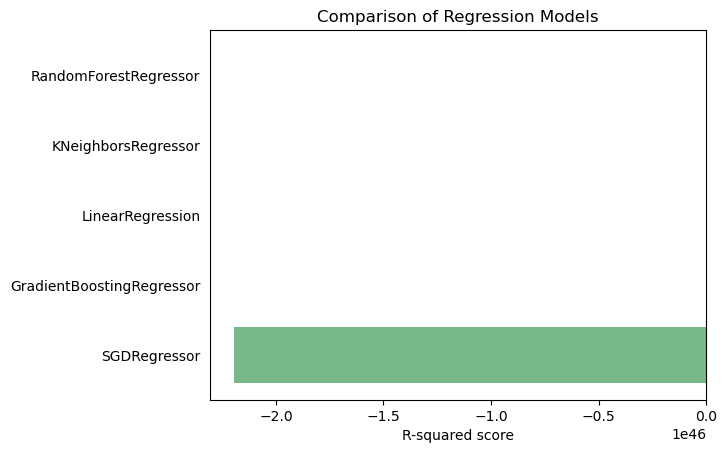

In [198]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [199]:
results

{'SGDRegressor': -2.1962692435910188e+46,
 'GradientBoostingRegressor': 0.046210005587431935,
 'LinearRegression': 0.056967895960904014,
 'KNeighborsRegressor': -0.22386013787130077,
 'RandomForestRegressor': -0.009050667379830957}

In [ ]:
df = raw.copy()
# Convert admit time to date time and calculate age at admission using MIMIC-IV
# anchor year mapping. Afterwards, finally, drop unnecessary columns.
df['admittime'] = pd.to_datetime(df['admittime'])
df['age'] = (df['admittime'].dt.year - df['anchor_year']) + df['anchor_age']
df.drop(columns=['admittime', 'anchor_year', 'anchor_age'], inplace=True)

# Replace race values with simplified values
# df['race'].replace(regex=r'^ASIAN', value='ASIAN', inplace=True)
# df['race'].replace(regex=r'^WHITE\b', value='WHITE', inplace=True)
# df['race'].replace(regex=r'^HISPANIC\b', value='HISPANIC/LATINO', inplace=True)
# df['race'].replace(regex=r'^BLACK\b', value='BLACK/AFRICAN AMERICAN', inplace=True)
# df['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
#                   value='OTHER/UNKNOWN', inplace=True)

df['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['race'].loc[~df['race'].isin(df['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

# # Replace first care unit with simplified values
# care_unit_patterns = {
#     r'^Medical/Surgical\b': 'MICU/SICU',
#     r'^Medical\b': 'MICU',
#     r'^Surgical\b': 'SICU',
#     r'^Cardiac\b': 'CVICU',
#     r'^Neuro\b': 'NSICU',
#     r'^Trauma\b': 'TSICU'
# }

# # Apply all replacements at once and set non-matching values to NaN
# df['first_careunit'] = (df['first_careunit']
#                        .replace(care_unit_patterns, regex=True)
#                        .where(df['first_careunit']
#                              .replace(care_unit_patterns, regex=True)
#                              .isin(care_unit_patterns.values())))

# # Option 1: Drop rows where first_careunit is NaN
# df = df.dropna(subset=['first_careunit'])

df['first_careunit'].replace(regex=r'^Medical/Surgical\D*', value='MICU,SICU', inplace=True)
df['first_careunit'].replace(regex=r'^Medical\D*', value='MICU', inplace=True)
df['first_careunit'].replace(regex=r'^Surgical\D*', value='SICU', inplace=True)
df['first_careunit'].replace(regex=r'^Cardiac\D*', value='CVICU', inplace=True)
df['first_careunit'].replace(regex=r'^Neuro\D*', value='NSICU', inplace=True)
df['first_careunit'].replace(regex=r'^Trauma\D*', value='TSICU', inplace=True)
df['first_careunit'].replace(regex=r'^Coronary\D*', value='CCU', inplace=True)
df['first_careunit'] = df['first_careunit'].mask(~df['first_careunit'].isin(df['first_careunit'].value_counts().nlargest(7).index.tolist()))
# df['first_careunit'].loc[~df['first_careunit'].isin(df['first_careunit'].value_counts().nlargest(7).index.tolist())] = None
# df = df.dropna(subset=['first_careunit'])
# ['MICU/SICU','MICU','NSICU','CVICU','CCU','TSICU','SICU']
# For each row in data aggregate ICU tie types into a list, then one-hot encode into separate columns.
# print(df['first_careunit'].value_counts().nlargest(7).index.tolist())
df['first_careunit'] = df['first_careunit'].str.split(',', expand=False).reset_index(drop=True)
df = df.join(pd.get_dummies(df['first_careunit'].apply(pd.Series).stack()).groupby(level=0).sum(), how='outer')

# Drop old unnecessary first care unit column
df.drop(columns=['first_careunit'], inplace=True)

# # Below code creates separate columns for each CBC lab event result
# # Group by subject id and hospital admission id and aggregate lab event results into list
# tmp = df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index()

# # Drop old lab event result columns
# df.drop(columns=['label', 'valuenum'], inplace=True)
# # Merge temporary aggregated list of results with data
# df = df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')
# del tmp

# df = df[df.apply(lambda x: len(x['label']) == 3, axis=1)]
# # Split aggregated list of values into separate columns. Then, drop unnecessary columns
# df = df.join(pd.DataFrame(df['valuenum'].to_list(), columns=df.iloc[0]['label']), how='outer')
# df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True)

tmp = df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index()

# Step 2: Drop old columns and merge
df.drop(columns=['label', 'valuenum'], inplace=True)
df = df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')
del tmp

# Step 3: Create a dictionary to store label-value pairs for each row
df['label_value_dict'] = df.apply(lambda x: dict(zip(x['label'], x['valuenum'])), axis=1)

# Step 4: Get all unique labels
unique_labels = set()
for labels in df['label']:
    unique_labels.update(labels)

# Step 5: Create new columns for each unique label
for label in unique_labels:
    df[label] = df['label_value_dict'].apply(lambda x: x.get(label, None))

# Step 6: Clean up intermediate columns
df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum', 'label_value_dict'], inplace=True)

# One-hot encode category columns (admission type, insurance, race, gender, location, and marital status)
prefix_cols = ['adm', 'ins', 'race', 'gender', 'loc', 'mar']
dummy_cols = ['admission_type', 'insurance', 'race', 'gender', 'admission_location', 'marital_status']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols, dtype=int)

# Drop duplicates, drop rows with NaN, and reset indices
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(columns=['index'], inplace=True)
# df.reset_index(True, inplace=True)

# (Optional) download resulting pandas DataFrame into a zipped CSV file
archive_name = 'processed_data.zip'
compression_opts = dict(method='zip', archive_name='processed_data.csv')
df.to_csv(archive_name, index=False, compression=compression_opts)

In [173]:
df = pd.read_csv('processed_data.zip', compression='zip')

In [180]:
df.head(1)

,hyperlipidemia,hospital_expire_flag,age,CCU,CVICU,MICU,NSICU,SICU,TSICU,"Cholesterol, LDL, Measured",...,loc_PACU,loc_PHYSICIAN REFERRAL,loc_PROCEDURE SITE,loc_TRANSFER FROM HOSPITAL,loc_TRANSFER FROM SKILLED NURSING FACILITY,loc_WALK-IN/SELF REFERRAL,mar_DIVORCED,mar_MARRIED,mar_SINGLE,mar_WIDOWED
